# Cover Type Classification via deep learning model
to predict the dominant forest cover type 'Spruce/Fir', 'Lodgepole Pine','Ponderosa Pine', 'Cottonwood/Willow','Aspen', 'Douglas-fir', 'Krummholz' from 54 cartographic variables.
## Data set: 
csv file ('cover_data.csv'), 581012 observations, 54 features and the class (cover type).

In [27]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

RSEED = 42

In [28]:
# Read in dataset
#df = pd.read_csv('cover_data.csv')

In [29]:
# Check classes for balance
from collections import Counter
Counter(df['class'])

Counter({5: 9493, 2: 283301, 1: 211840, 7: 20510, 3: 35754, 6: 17367, 4: 2747})

The dataset is imbalanced. Classes 1 and 2 make for most of the data. We might achieve high accuracy with a poor classification of minority classes.

# Preprocessing function

Without any separate test dataset, part of the data are to be used as test data.

In [30]:
def prepare_data(df):
    # Separate target and features, transform class integers into one-hot vector in target (y)
    data = df.values
    X, y = data[:, :-1], data[:, -1]

    # One-hot encode target column
    y = tf.keras.utils.to_categorical(y, dtype = 'int64')

    # Split data with stratification (slight imbalance for classes 4 and 5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RSEED, stratify=y)

    # Scale data with Standard Scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


# Design model

In [31]:
def design_model(num_features):
    
    model = Sequential()
    model.add(InputLayer(input_shape=(num_features,)))
    model.add(Dense(64, activation='relu'))
    #model.add(layers.Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    #model.add(layers.Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Creating a heatmap function

In [32]:
def plot_heatmap(kind_names, y_pred, y_test):
    cfm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(18, 18))
    heatmap = sns.heatmap(cfm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_title('Confusion Matrix')
    ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
    ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
    ax.set_xticklabels(kind_names)
    ax.set_yticklabels(kind_names)

# ... and a plotting function

In [33]:
def plot_history(history, param):
    """
    Monitor model performance (in terms of accuracy and loss) over several epochs.
    """
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

# Main function to train and evaluate the model

In [34]:
def main():
    data = 'cover_data.csv'
    df = pd.read_csv(data)

    cols = df.columns.tolist()
    features, label = cols[:-1], cols[-1]
    X_train, X_test, y_train, y_test = prepare_data(df)

    # Build a DL model
    num_features = len(features)
    model = design_model(num_features)

    print("Summary report of Keras classifier:")
    model.summary()

    num_epochs = 100
    batch_size = 1024
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)
    history = model.fit(X_train,
                    y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    callbacks=[earlystop_callback],
                    validation_split=0.1,
                    verbose=1)

    plot_history(history, 'acc')
    plot_history(history, 'loss')

    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    y_pred = model.predict(X_test)

    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    kind_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=kind_names))
    plot_heatmap(kind_names, y_pred, y_test)

Summary report of Keras classifier:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                3520      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 264       
Total params: 5,864
Trainable params: 5,864
Non-trainable params: 0
_________________________________________________________________


2021-10-27 12:26:39.806542: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 90358848 exceeds 10% of free system memory.


Epoch 1/100
409/409 [==============================] - 4s 8ms/step - loss: 0.7893 - accuracy: 0.6936 - val_loss: 0.6075 - val_accuracy: 0.7436
Epoch 2/100
409/409 [==============================] - 3s 7ms/step - loss: 0.5806 - accuracy: 0.7547 - val_loss: 0.5582 - val_accuracy: 0.7622
Epoch 3/100
409/409 [==============================] - 3s 8ms/step - loss: 0.5433 - accuracy: 0.7693 - val_loss: 0.5310 - val_accuracy: 0.7736
Epoch 4/100
409/409 [==============================] - 3s 8ms/step - loss: 0.5173 - accuracy: 0.7797 - val_loss: 0.5087 - val_accuracy: 0.7837
Epoch 5/100
409/409 [==============================] - 3s 8ms/step - loss: 0.4976 - accuracy: 0.7884 - val_loss: 0.4951 - val_accuracy: 0.7910
Epoch 6/100
409/409 [==============================] - 3s 7ms/step - loss: 0.4817 - accuracy: 0.7962 - val_loss: 0.4817 - val_accuracy: 0.7947
Epoch 7/100
409/409 [==============================] - 3s 8ms/step - loss: 0.4685 - accuracy: 0.8025 - val_loss: 0.4670 - val_accuracy: 0.8041

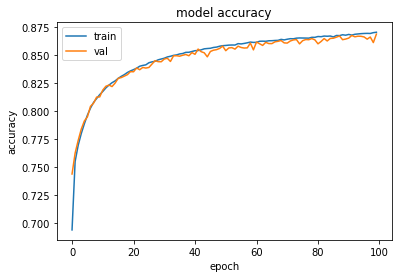

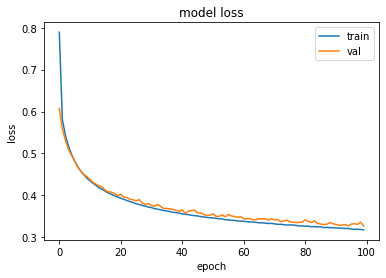

Test loss: 0.3283297121524811
Test accuracy: 0.8671548962593079
                   precision    recall  f1-score   support

       Spruce/Fir       0.88      0.84      0.86     42368
   Lodgepole Pine       0.87      0.92      0.89     56661
   Ponderosa Pine       0.85      0.86      0.85      7151
Cottonwood/Willow       0.85      0.68      0.75       549
            Aspen       0.78      0.53      0.63      1899
      Douglas-fir       0.75      0.64      0.69      3473
        Krummholz       0.89      0.84      0.86      4102

         accuracy                           0.87    116203
        macro avg       0.84      0.76      0.79    116203
     weighted avg       0.87      0.87      0.87    116203



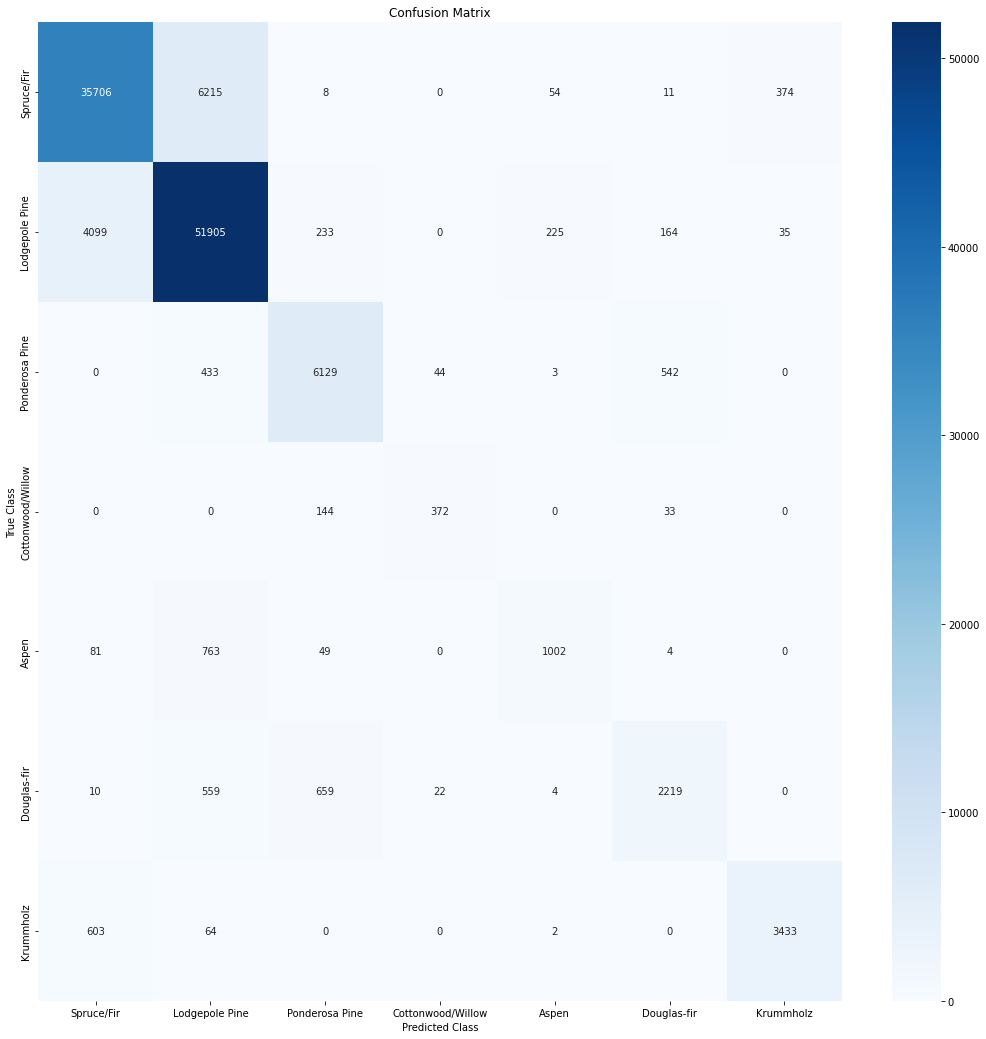

In [35]:
if __name__ == '__main__':
    main()

# Conclusions: 

While the smallest class reaches good precision, Aspen and Douglas-Fir are particularly weak in recall. They suffer from high rates of misclassification that should be investigated on further. For all three classes, a lower f1 indicates a weaker success in classification through weaker recall. Without further information on how the results are to be used, our result might be sufficient or not.

The majority classes Spruce/Fir and Lodgepole Pine achieve excellent f1 values. This represents high precision as well as high recall. The gradients of the majority classes have the strongest influence on updating connection weights. A follow-up model could try to undersample/oversample classes to achieve a model that is more successful in recall throughout the classes.

